In [ ]:
class CVRP:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, customer_demands, distances, depot, shelter):
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_demands = customer_demands
        self.distances = distances
        self.depot = depot
        self.shelter = shelter
        self.num_locations = num_customers + 2  # Including depot and shelter
        self.y = np.zeros((self.num_locations, self.num_vehicles))  # y[i][k] -> if vehicle k visits location i
        self.x = np.zeros((self.num_locations, self.num_locations, self.num_vehicles))  # x[i][j][k] -> if vehicle k moves from i to j
        self.q = np.zeros((self.num_locations, self.num_vehicles))  # q[i][k] -> cargo at location i for vehicle k

    def check_capacity(self, i, k, j):
        # Checks if the vehicle can pick up more cargo at location i and move to location j
        if self.q[i][k] + self.customer_demands[j] > self.vehicle_capacity:
            return False
        return True

    def objective_function(self):
        # Objective is to minimize the total distance
        total_distance = 0
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    total_distance += self.distances[i][j] * self.x[i][j][k]
        return total_distance

    def apply_constraints(self):
        # 3.2: Each customer must be visited exactly once by one vehicle
        for i in range(1, self.num_locations - 1):  # Exclude depot and shelter
            if np.sum(self.y[i]) != 1:
                return False

        # 3.3: If vehicle k visits i, then it must move to j
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if np.sum(self.x[i, :, k]) != self.y[i, k]:  # If x[i,j,k] is 1, y[i,k] must be 1
                    return False

        # 3.4: If vehicle k moves from i to j, y[j,k] must be 1
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if np.sum(self.x[:, i, k]) != self.y[i, k]:  # If x[i,j,k] is 1, y[j,k] must be 1
                    return False

        # 3.5: Ensure cargo does not exceed vehicle capacity
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if self.q[i][k] + self.customer_demands[i] > self.vehicle_capacity:
                    return False

        # 3.6: Ensure vehicle cargo at destination does not exceed capacity
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    if self.q[i][k] + self.customer_demands[j] > self.vehicle_capacity:
                        return False

        # 3.7: Update cargo at location j after visiting i
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    if self.x[i, j, k] == 1:  # If vehicle k moves from i to j
                        self.q[j][k] = self.q[i][k] + self.customer_demands[j]  # Update cargo at j after moving from i to j
                    if self.q[j][k] > self.vehicle_capacity:  # Check capacity constraint
                        return False

        # 3.8: Define set S as the visited locations
        S = set()
        for k in range(self.num_vehicles):
            for i in range(1, self.num_locations - 1):
                if self.y[i, k] == 1:
                    S.add(i)
        # Check if S includes all necessary points
        if len(S) != self.num_customers:  # Should visit all customers, excluding depot and shelter
            return False

        # 3.9: Vehicle must go to shelter if its capacity is exceeded
        for k in range(self.num_vehicles):
            for j in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.q[j, k] > self.vehicle_capacity:
                    self.x[j, self.shelter, k] = 1  # Force vehicle k to go to shelter

        # 3.10: Vehicle must go to shelter if it doesn't visit any other location
        for k in range(self.num_vehicles):
            for j in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.y[j, k] == 0:
                    self.x[j, self.shelter, k] = 1  # Force vehicle k to go to shelter if j is not visited

        # 3.11: Vehicle must depart from depot and visit another location
        for k in range(self.num_vehicles):
            if np.sum(self.x[self.depot, :, k]) == 0:  # Vehicle must move away from depot
                return False

        # 3.12: Vehicle must visit shelter exactly once
        for k in range(self.num_vehicles):
            if np.sum(self.x[:, self.shelter, k]) != 1:
                return False

        # 3.13: Vehicle must return to depot after visiting shelter
        for k in range(self.num_vehicles):
            if self.x[self.shelter, self.depot, k] != 1:
                return False

        # 3.14: Total cargo at shelter cannot exceed shelter's capacity
        total_cargo_at_shelter = 0
        for k in range(self.num_vehicles):
            for i in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.x[i, self.shelter, k] == 1:
                    total_cargo_at_shelter += self.q[i, k]
        if total_cargo_at_shelter > self.vehicle_capacity:
            return False

        return True

Iterasi 1: Jarak Terbaik = 49.0
Iterasi 2: Jarak Terbaik = 32.0
Iterasi 3: Jarak Terbaik = 32.0
Iterasi 4: Jarak Terbaik = 32.0
Iterasi 5: Jarak Terbaik = 32.0
Iterasi 6: Jarak Terbaik = 32.0
Iterasi 7: Jarak Terbaik = 32.0
Iterasi 8: Jarak Terbaik = 32.0
Iterasi 9: Jarak Terbaik = 32.0
Iterasi 10: Jarak Terbaik = 32.0
Iterasi 11: Jarak Terbaik = 32.0
Konvergen pada iterasi 12


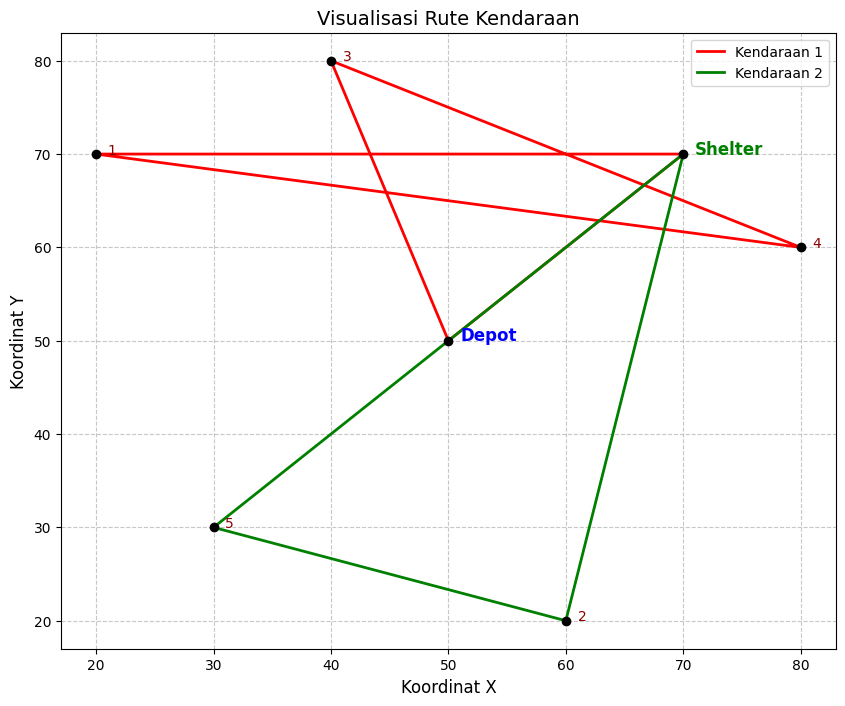


Rute Terbaik:
Kendaraan 1: [0, 3, 4, 1, 6, 0]
Kendaraan 2: [0, 5, 2, 6, 0]
Jarak Total Terbaik: 32.0


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class CVRP:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, customer_demands, distances, depot, shelter, A_cap=20, epsilon=4):
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_demands = customer_demands
        self.distances = distances
        self.depot = depot
        self.shelter = shelter
        self.num_locations = num_customers + 2  # Including depot and shelter
        self.A_cap = A_cap  # Maximum explosion amplitude
        self.epsilon = epsilon  # Epsilon for avoiding division by zero

    def calculate_total_distance(self, routes):
        total_distance = 0
        for route in routes:
            for i in range(len(route) - 1):
                total_distance += self.distances[route[i]][route[i + 1]]
        return total_distance

    def generate_initial_solution(self):
        points = list(range(1, self.num_locations - 1))  # Points exclude depot and shelter
        random.shuffle(points)
        routes = [[] for _ in range(self.num_vehicles)]
        current_loads = [0] * self.num_vehicles

        for point in points:
            for v in range(self.num_vehicles):
                if current_loads[v] + self.customer_demands[point] <= self.vehicle_capacity:
                    routes[v].append(point)
                    current_loads[v] += self.customer_demands[point]
                    break

        for route in routes:
            route.insert(0, self.depot)  # Start with depot
            route.append(self.shelter)  # End with shelter
            route.append(self.depot)  # Return to depot after shelter
        return routes

    def generate_sparks(self, solution, num_sparks, explosion_amplitude):
        sparks = []
        y_max = self.calculate_total_distance(solution)  # Max distance in the current solution
        y_min = min(self.calculate_total_distance(solution), 10000)  # Min distance for the normalization
        sum_distance = sum([self.calculate_total_distance(solution) for _ in range(num_sparks)])

        for _ in range(num_sparks):
            spark = [list(route) for route in solution]
            # Calculate explosion size
            S_i = (explosion_amplitude * (y_max - self.calculate_total_distance(spark) + self.epsilon)) / sum_distance
            # Apply constraints to S_i
            if S_i < explosion_amplitude * 0.004:
                S_i = round(explosion_amplitude * 0.004)
            elif S_i > explosion_amplitude * 0.8:
                S_i = round(explosion_amplitude * 0.8)
            else:
                S_i = round(S_i)

            # Amplitude calculation
            A_i = self.A_cap * (self.calculate_total_distance(spark) - y_min + self.epsilon) / sum_distance

            # Apply moves based on amplitude (Two-point swap, subsequence reversal, segment exchange, insertion move)
            if random.random() < A_i:
                vehicle = random.randint(0, len(spark) - 1)
                if len(spark[vehicle]) > 3:
                    idx1, idx2 = random.sample(range(1, len(spark[vehicle]) - 1), 2)
                    spark[vehicle][idx1], spark[vehicle][idx2] = spark[vehicle][idx2], spark[vehicle][idx1]

            # Apply 2-opt move after amplitude calculation
            self.apply_2opt(spark)

            sparks.append(spark)
        return sparks

    def apply_2opt(self, solution):
        # 2-opt algorithm to improve the solution by swapping two edges
        for route in solution:
            if len(route) > 4:  # Ensure the route has enough length for 2-opt swap
                for i in range(1, len(route) - 2):
                    for j in range(i + 1, len(route) - 1):
                        if j - i == 1: continue  # Skip adjacent nodes
                        new_route = route[:]
                        new_route[i:j+1] = reversed(route[i:j+1])
                        if self.calculate_total_distance([new_route]) < self.calculate_total_distance([route]):
                            route[i:j+1] = reversed(route[i:j+1])

    def select_best_solutions(self, solutions, max_solutions):
        valid_solutions = []
        for s in solutions:
            if self.is_valid_solution(s):
                valid_solutions.append(s)
        valid_solutions.sort(key=lambda s: self.calculate_total_distance(s))
        return valid_solutions[:max_solutions]

    def is_valid_solution(self, routes):
        for route in routes:
            total_demand = sum(self.customer_demands[node] for node in route if node != self.depot and node != self.shelter)
            if total_demand > self.vehicle_capacity:
                return False
            # Ensure vehicle returns to depot after shelter
            if self.shelter in route:
                shelter_idx = route.index(self.shelter)
                if shelter_idx != len(route) - 2:  # Ensure the second-to-last location is the depot
                    return False
        return True

    def fireworks_algorithm(self, num_sparks=50, explosion_amplitude=4, max_iter=100, convergence_threshold=10):
        current_solution = self.generate_initial_solution()
        best_solution = current_solution
        best_distance = self.calculate_total_distance(best_solution)
        best_distances = [best_distance]
        no_improvement_iter = 0  # Counter for no improvement

        for iteration in range(max_iter):
            sparks = self.generate_sparks(current_solution, num_sparks, explosion_amplitude)
            sparks.append(best_solution)
            current_solution = self.select_best_solutions(sparks, 1)[0]

            current_distance = self.calculate_total_distance(current_solution)
            if current_distance < best_distance:
                best_solution = current_solution
                best_distance = current_distance
                best_distances.append(best_distance)
                no_improvement_iter = 0
            else:
                no_improvement_iter += 1

            # Check for convergence (if no improvement for several iterations)
            if no_improvement_iter >= convergence_threshold:
                print(f"Konvergen pada iterasi {iteration + 1}")
                break

            print(f"Iterasi {iteration + 1}: Jarak Terbaik = {best_distance}")

        return best_solution, best_distance

# Data masalah
distance_matrix = np.array([
    [0, 3.0, 6.0, 1.0, 9.0, 4.0, 5.0],
    [7.0, 0, 1.0, 7.0, 6.0, 8.0, 4.5],
    [4.0, 8.0, 0, 8.0, 7.0, 9.0, 8.5],
    [5.0, 9.0, 3.0, 0, 1.0, 9.0, 7.5],
    [7.0, 1.0, 7.0, 3.0, 0, 5.0, 6.0],
    [3.0, 9.0, 3.0, 5.0, 1.0, 0, 5.5],
    [4.5, 4.5, 5.5, 5.5, 6.5, 7.5, 0]
])
customer_demands = [0, 70, 50, 40, 40, 60, 0]
vehicle_capacity = 150
num_vehicles = 2
depot = 0
shelter = 6
A_cap = 20
epsilon = 4

# Eksekusi model
cvrp = CVRP(num_customers=5, num_vehicles=num_vehicles, vehicle_capacity=vehicle_capacity,
            customer_demands=customer_demands, distances=distance_matrix, depot=depot, shelter=shelter)
best_routes, best_distance = cvrp.fireworks_algorithm()

# Koordinat lokasi untuk visualisasi
coordinates = {
    0: (50, 50),  # Depot
    1: (20, 70),  # Customer 1
    2: (60, 20),  # Customer 2
    3: (40, 80),  # Customer 3
    4: (80, 60),  # Customer 4
    5: (30, 30),  # Customer 5
    6: (70, 70)   # Shelter
}

# Visualisasi rute terbaik
def visualize_routes(routes, coordinates):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Warna untuk kendaraan
    plt.figure(figsize=(10, 8))

    # Plot lokasi dan labelnya
    for node, (x, y) in coordinates.items():
        plt.scatter(x, y, c='black', zorder=5)
        if node == 0:
            plt.text(x + 1, y, 'Depot', fontsize=12, fontweight='bold', color='blue')
        elif node == 6:
            plt.text(x + 1, y, 'Shelter', fontsize=12, fontweight='bold', color='green')
        else:
            plt.text(x + 1, y, f'{node}', fontsize=10, color='darkred')

    # Plot rute kendaraan
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        x_coords = [coordinates[node][0] for node in route]
        y_coords = [coordinates[node][1] for node in route]
        plt.plot(x_coords, y_coords, linestyle='-', linewidth=2, color=color, label=f'Kendaraan {i + 1}')

    plt.title('Visualisasi Rute Kendaraan', fontsize=14)
    plt.xlabel('Koordinat X', fontsize=12)
    plt.ylabel('Koordinat Y', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

visualize_routes(best_routes, coordinates)
print("\nRute Terbaik:")
for vehicle, route in enumerate(best_routes):
    print(f"Kendaraan {vehicle + 1}: {route}")
print(f"Jarak Total Terbaik: {best_distance}")
